<a href="https://colab.research.google.com/github/akjames/tensor-decomp-FTS-1/blob/main/FTS_tensor_decomp_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 36.3 MB/s eta 0:00:00


Loading DistilBERT model...


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Model structure: 6 layers, 12 heads, 768 hidden size
Head dimension: 64

STARTING DISTILBERT ATTENTION ANALYSIS

Extracting weights from layer 0...
Weight matrix shapes: Q=torch.Size([768, 768]), K=torch.Size([768, 768]), V=torch.Size([768, 768])
Head matrices shape: torch.Size([12, 64, 768]) (heads, head_dim, hidden_size)

=== Analysis for Layer 0 ===

1. Query (Q) Matrix Head Similarities:


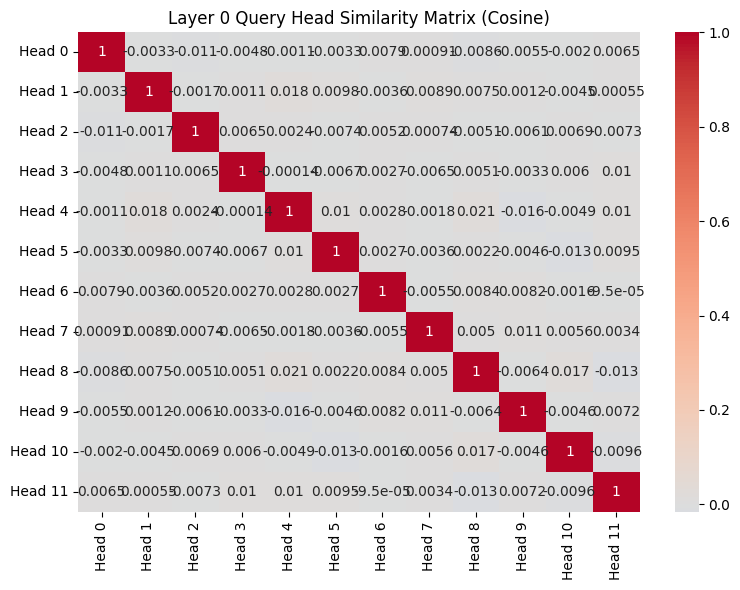


2. Key (K) Matrix Head Similarities:


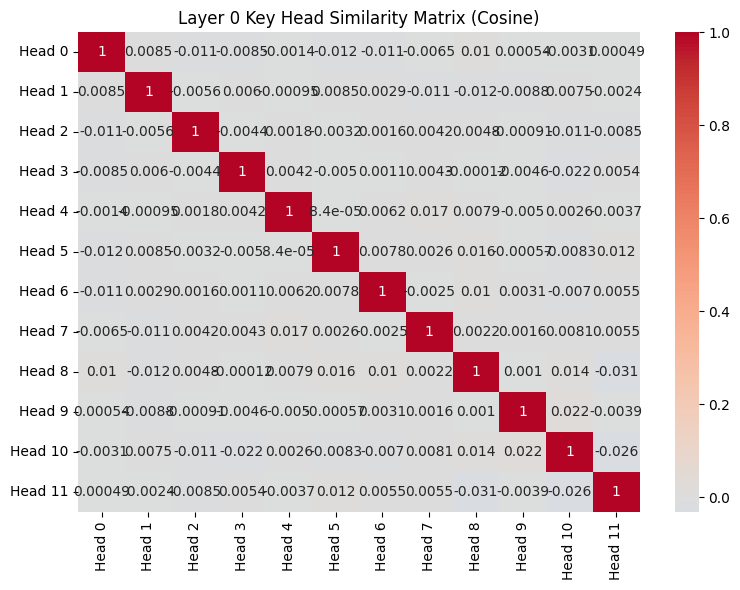


3. Value (V) Matrix Head Similarities:


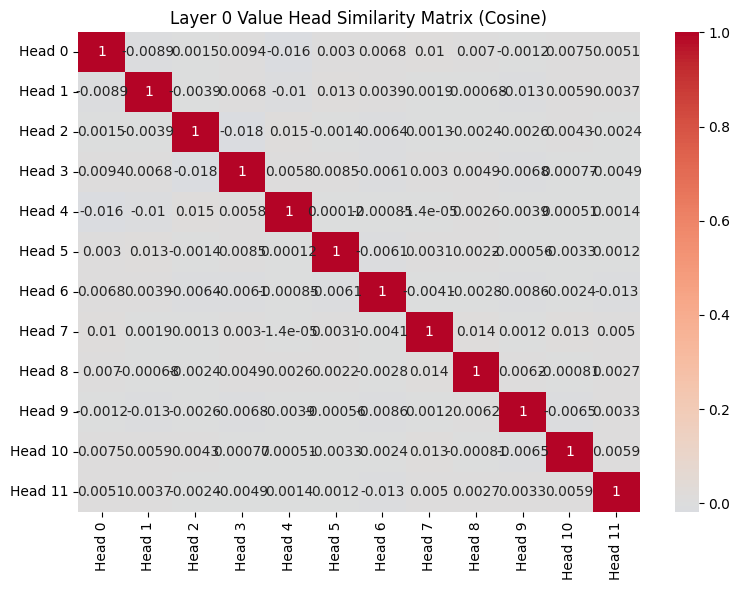


4. Checking for Rotational Relationships:
  Heads 0-1: Q_error=0.490, K_error=0.410, V_error=0.285
  Heads 0-5: Q_error=0.448, K_error=0.377, V_error=0.261
  Heads 0-7: Q_error=0.544, K_error=0.354, V_error=0.294
  Heads 0-11: Q_error=0.442, K_error=0.414, V_error=0.267
  Heads 1-2: Q_error=0.378, K_error=0.399, V_error=0.243
  Heads 1-3: Q_error=0.434, K_error=0.502, V_error=0.261
  Heads 1-4: Q_error=0.528, K_error=0.389, V_error=0.263
  Heads 1-5: Q_error=0.370, K_error=0.309, V_error=0.201
  Heads 1-6: Q_error=0.585, K_error=0.445, V_error=0.245
  Heads 1-7: Q_error=0.493, K_error=0.359, V_error=0.227
  Heads 1-8: Q_error=0.459, K_error=0.477, V_error=0.223
  Heads 1-9: Q_error=0.395, K_error=0.321, V_error=0.222
  Heads 1-10: Q_error=0.352, K_error=0.377, V_error=0.290
  Heads 1-11: Q_error=0.350, K_error=0.326, V_error=0.214
  Heads 2-3: Q_error=0.551, K_error=0.713, V_error=0.237
  Heads 2-4: Q_error=0.628, K_error=0.714, V_error=0.278
  Heads 2-5: Q_error=0.389, K_error=0.437,

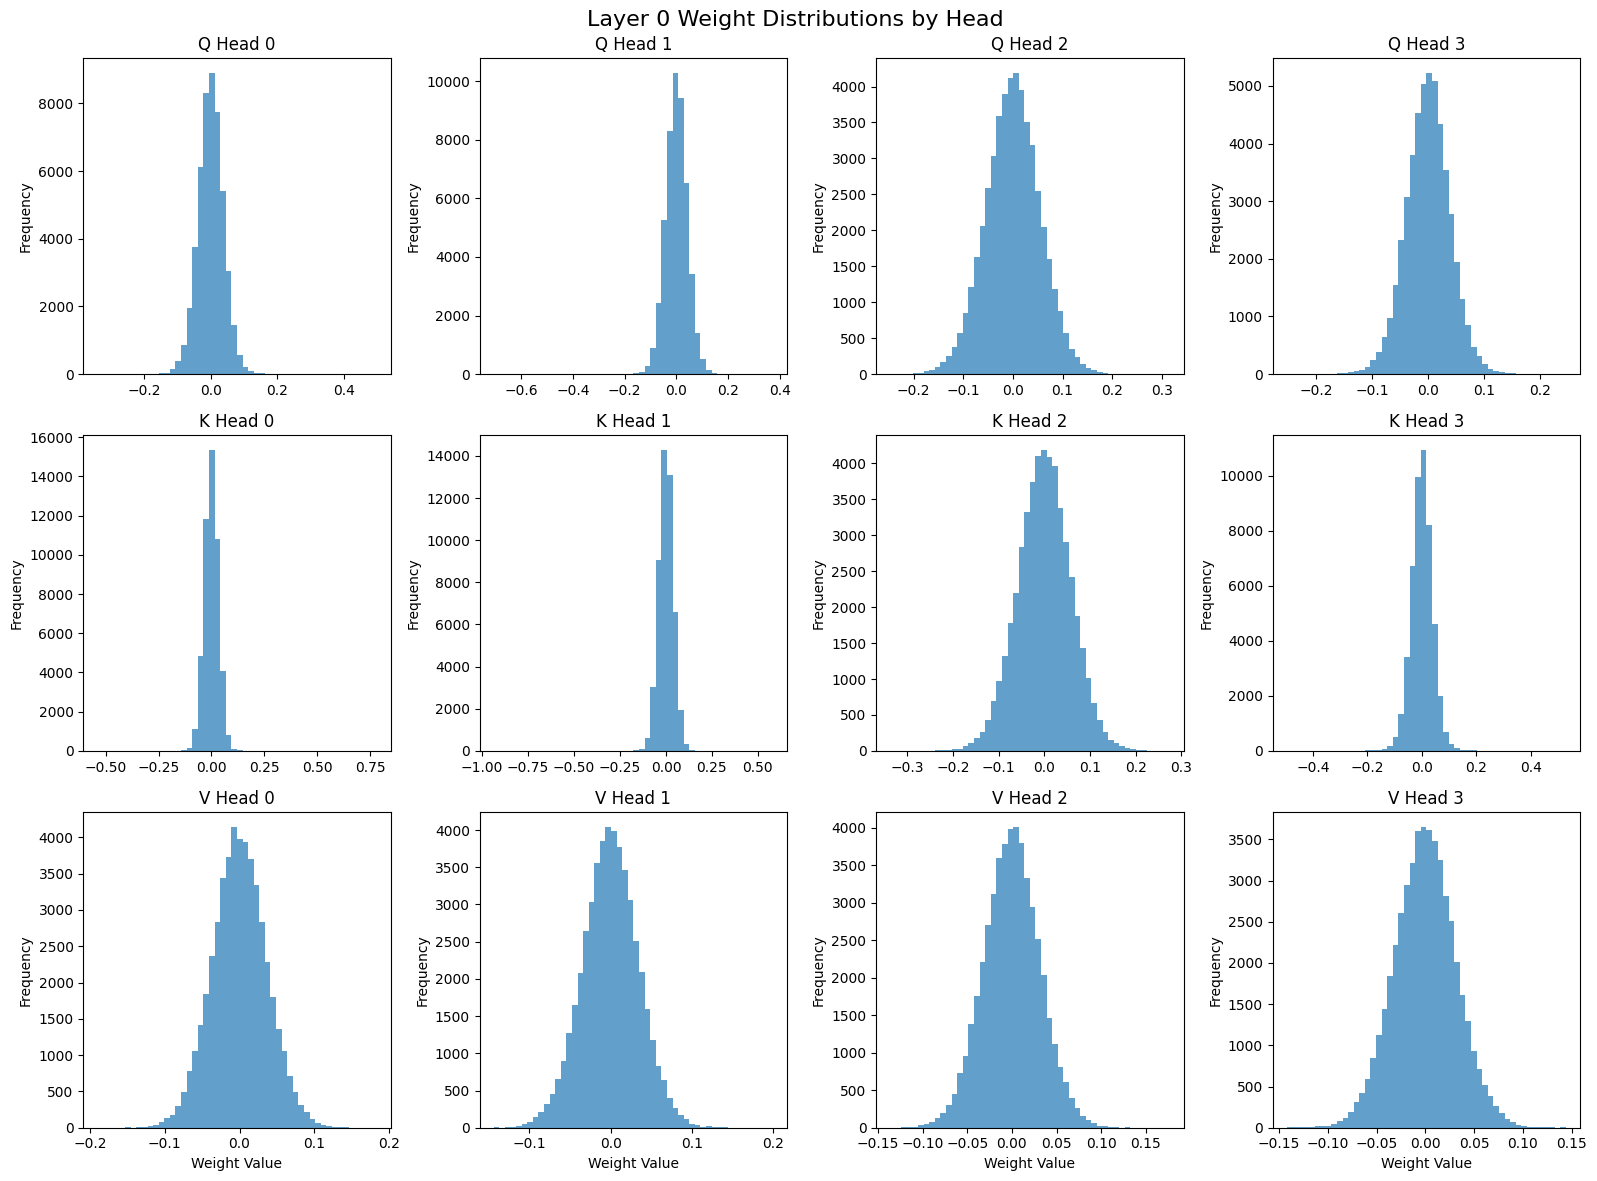


SUMMARY STATISTICS

Query Head Similarities (off-diagonal):
  Mean: 0.001, Std: 0.008
  Max: 0.021, Min: -0.016

Key Head Similarities (off-diagonal):
  Mean: -0.000, Std: 0.009
  Max: 0.022, Min: -0.031

Value Head Similarities (off-diagonal):
  Mean: 0.001, Std: 0.007
  Max: 0.015, Min: -0.018

Best Rotational Relationships (error < 0.5):
  Heads (5, 11): Q=0.275, K=0.239, V=0.185
  Heads (1, 5): Q=0.370, K=0.309, V=0.201
  Heads (1, 11): Q=0.350, K=0.326, V=0.214
  Heads (2, 9): Q=0.490, K=0.553, V=0.214
  Heads (5, 7): Q=0.458, K=0.321, V=0.217

Analysis complete! Check the plots above for visual patterns.


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import DistilBertModel
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import orthogonal_procrustes
import warnings
warnings.filterwarnings('ignore')

print("Loading DistilBERT model...")
model = DistilBertModel.from_pretrained('distilbert-base-uncased')
model.eval()

# DistilBERT has 6 layers, 12 heads per layer, 768 hidden size
num_layers = 6
num_heads = 12
hidden_size = 768
head_dim = hidden_size // num_heads  # 64

print(f"Model structure: {num_layers} layers, {num_heads} heads, {hidden_size} hidden size")
print(f"Head dimension: {head_dim}")

def extract_attention_weights(model, layer_idx=0):
    """Extract Q, K, V weights from a specific layer"""
    attention_layer = model.transformer.layer[layer_idx].attention

    # Get the combined QKV weight matrix [768, 2304] = [768, 3*768]
    qkv_weight = attention_layer.q_lin.weight, attention_layer.k_lin.weight, attention_layer.v_lin.weight

    q_weight = qkv_weight[0]  # [768, 768]
    k_weight = qkv_weight[1]  # [768, 768]
    v_weight = qkv_weight[2]  # [768, 768]

    return q_weight, k_weight, v_weight

def reshape_to_heads(weight_matrix, num_heads, head_dim):
    """Reshape weight matrix to show individual heads"""
    # weight_matrix: [768, 768]
    # Reshape to [num_heads, head_dim, hidden_size]
    return weight_matrix.view(num_heads, head_dim, -1)

def analyze_head_similarities(weight_matrices, matrix_name=""):
    """Analyze similarities between attention heads"""
    num_heads = weight_matrices.shape[0]

    # Flatten each head matrix for comparison
    flattened_heads = weight_matrices.view(num_heads, -1).detach().numpy()

    # Compute cosine similarities between heads
    similarities = cosine_similarity(flattened_heads)

    # Plot similarity matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarities, annot=True, cmap='coolwarm', center=0,
                xticklabels=[f'Head {i}' for i in range(num_heads)],
                yticklabels=[f'Head {i}' for i in range(num_heads)])
    plt.title(f'{matrix_name} Head Similarity Matrix (Cosine)')
    plt.tight_layout()
    plt.show()

    return similarities

def detect_rotational_relationships(head1, head2):
    """Check if head2 is approximately a rotation of head1"""
    # Use Orthogonal Procrustes to find best rotation matrix
    R, scale = orthogonal_procrustes(head1.detach().numpy(), head2.detach().numpy())

    # Apply the rotation
    rotated_head1 = head1.detach().numpy() @ R

    # Compute reconstruction error
    error = np.linalg.norm(rotated_head1 - head2.detach().numpy(), 'fro')
    relative_error = error / np.linalg.norm(head2.detach().numpy(), 'fro')

    return R, relative_error, scale

def analyze_functional_patterns(q_heads, k_heads, v_heads, layer_idx=0):
    """Look for functional patterns between heads"""
    print(f"\n=== Analysis for Layer {layer_idx} ===")

    num_heads = q_heads.shape[0]

    # 1. Analyze Q matrix similarities
    print("\n1. Query (Q) Matrix Head Similarities:")
    q_similarities = analyze_head_similarities(q_heads, f"Layer {layer_idx} Query")

    # 2. Analyze K matrix similarities
    print("\n2. Key (K) Matrix Head Similarities:")
    k_similarities = analyze_head_similarities(k_heads, f"Layer {layer_idx} Key")

    # 3. Analyze V matrix similarities
    print("\n3. Value (V) Matrix Head Similarities:")
    v_similarities = analyze_head_similarities(v_heads, f"Layer {layer_idx} Value")

    # 4. Look for rotational relationships
    print("\n4. Checking for Rotational Relationships:")
    rotation_results = []

    for i in range(num_heads):
        for j in range(i+1, num_heads):
            # Check Q matrices
            R_q, error_q, scale_q = detect_rotational_relationships(q_heads[i], q_heads[j])

            # Check K matrices
            R_k, error_k, scale_k = detect_rotational_relationships(k_heads[i], k_heads[j])

            # Check V matrices
            R_v, error_v, scale_v = detect_rotational_relationships(v_heads[i], v_heads[j])

            rotation_results.append({
                'heads': (i, j),
                'q_error': error_q,
                'k_error': error_k,
                'v_error': error_v,
                'q_scale': scale_q,
                'k_scale': scale_k,
                'v_scale': scale_v
            })

            if error_q < 0.3 or error_k < 0.3 or error_v < 0.3:  # Threshold for "similar"
                print(f"  Heads {i}-{j}: Q_error={error_q:.3f}, K_error={error_k:.3f}, V_error={error_v:.3f}")

    return q_similarities, k_similarities, v_similarities, rotation_results

def plot_weight_distributions(q_heads, k_heads, v_heads, layer_idx=0):
    """Plot weight distributions for each head"""
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle(f'Layer {layer_idx} Weight Distributions by Head', fontsize=16)

    for head_idx in range(min(4, q_heads.shape[0])):  # Plot first 4 heads
        # Q weights
        axes[0, head_idx].hist(q_heads[head_idx].flatten().detach().numpy(), bins=50, alpha=0.7)
        axes[0, head_idx].set_title(f'Q Head {head_idx}')
        axes[0, head_idx].set_ylabel('Frequency')

        # K weights
        axes[1, head_idx].hist(k_heads[head_idx].flatten().detach().numpy(), bins=50, alpha=0.7)
        axes[1, head_idx].set_title(f'K Head {head_idx}')
        axes[1, head_idx].set_ylabel('Frequency')

        # V weights
        axes[2, head_idx].hist(v_heads[head_idx].flatten().detach().numpy(), bins=50, alpha=0.7)
        axes[2, head_idx].set_title(f'V Head {head_idx}')
        axes[2, head_idx].set_ylabel('Frequency')
        axes[2, head_idx].set_xlabel('Weight Value')

    plt.tight_layout()
    plt.show()

# Main Analysis
print("\n" + "="*50)
print("STARTING DISTILBERT ATTENTION ANALYSIS")
print("="*50)

# Analyze first layer (layer 0)
layer_to_analyze = 0
print(f"\nExtracting weights from layer {layer_to_analyze}...")

q_weight, k_weight, v_weight = extract_attention_weights(model, layer_to_analyze)
print(f"Weight matrix shapes: Q={q_weight.shape}, K={k_weight.shape}, V={v_weight.shape}")

# Reshape to show individual heads
q_heads = reshape_to_heads(q_weight, num_heads, head_dim)
k_heads = reshape_to_heads(k_weight, num_heads, head_dim)
v_heads = reshape_to_heads(v_weight, num_heads, head_dim)

print(f"Head matrices shape: {q_heads.shape} (heads, head_dim, hidden_size)")

# Run comprehensive analysis
q_sim, k_sim, v_sim, rotation_results = analyze_functional_patterns(q_heads, k_heads, v_heads, layer_to_analyze)

# Plot weight distributions
plot_weight_distributions(q_heads, k_heads, v_heads, layer_to_analyze)

# Summary statistics
print("\n" + "="*50)
print("SUMMARY STATISTICS")
print("="*50)

print(f"\nQuery Head Similarities (off-diagonal):")
q_off_diag = q_sim[np.triu_indices_from(q_sim, k=1)]
print(f"  Mean: {np.mean(q_off_diag):.3f}, Std: {np.std(q_off_diag):.3f}")
print(f"  Max: {np.max(q_off_diag):.3f}, Min: {np.min(q_off_diag):.3f}")

print(f"\nKey Head Similarities (off-diagonal):")
k_off_diag = k_sim[np.triu_indices_from(k_sim, k=1)]
print(f"  Mean: {np.mean(k_off_diag):.3f}, Std: {np.std(k_off_diag):.3f}")
print(f"  Max: {np.max(k_off_diag):.3f}, Min: {np.min(k_off_diag):.3f}")

print(f"\nValue Head Similarities (off-diagonal):")
v_off_diag = v_sim[np.triu_indices_from(v_sim, k=1)]
print(f"  Mean: {np.mean(v_off_diag):.3f}, Std: {np.std(v_off_diag):.3f}")
print(f"  Max: {np.max(v_off_diag):.3f}, Min: {np.min(v_off_diag):.3f}")

# Find best rotational relationships
print(f"\nBest Rotational Relationships (error < 0.5):")
good_rotations = [r for r in rotation_results if min(r['q_error'], r['k_error'], r['v_error']) < 0.5]
if good_rotations:
    for r in sorted(good_rotations, key=lambda x: min(x['q_error'], x['k_error'], x['v_error']))[:5]:
        print(f"  Heads {r['heads']}: Q={r['q_error']:.3f}, K={r['k_error']:.3f}, V={r['v_error']:.3f}")
else:
    print("  No strong rotational relationships found")

print(f"\nAnalysis complete! Check the plots above for visual patterns.")

Starting FFN Sub-Block Procrustes Analysis


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Linear1 weight shape: (3072, 768)
Total parameters in Linear1: 2359296
Matrix shape: (3072, 768)
Block size: 64x64
Number of complete blocks: 48 x 12 = 576
Analyzing relationships between 576 blocks
Total possible pairs: 165600
Limiting analysis to first 1000 pairs for computational efficiency
Processed 100 pairs...
Processed 200 pairs...
Processed 300 pairs...
Processed 400 pairs...
Processed 500 pairs...
Processed 600 pairs...
Processed 700 pairs...
Processed 800 pairs...
Processed 900 pairs...
Processed 1000 pairs...

BEST ROTATIONAL RELATIONSHIPS (Lowest Procrustes Error)
Rank 1:
  Blocks (0, 4) at positions (0,0) → (0,4)
  Row ranges: 0-64 → 0-64
  Col ranges: 0-64 → 256-320
  Procrustes error: 0.650852
  Scale factor: 1.041994
  Rotation matrix norm: 8.000000

Rank 2:
  Blocks (1, 3) at positions (0,1) → (0,3)
  Row ranges: 0-64 → 0-64
  Col ranges: 64-128 → 192-256
  Procrustes error: 0.662020
  Scale factor: 1.039947
  Rotation matrix norm: 8.000001

Rank 3:
  Blocks (1, 4) at 

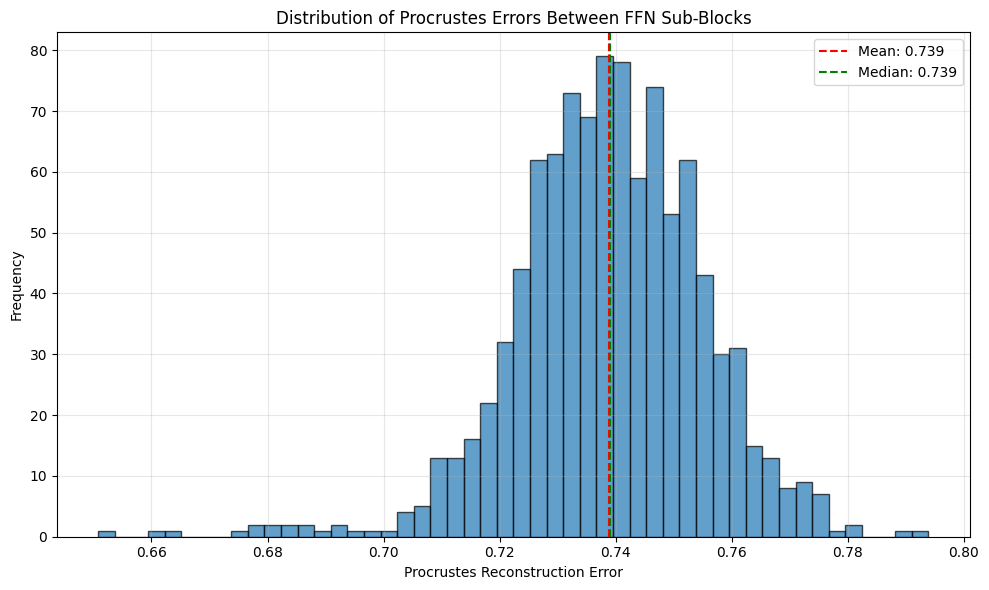


SPATIAL PATTERN ANALYSIS
Diagonal-related relationships: 2/20
Adjacent relationships: 2/20

ANALYSIS COMPLETE


In [ ]:
import torch
import numpy as np
from transformers import DistilBertModel
from scipy.linalg import orthogonal_procrustes
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import pandas as pd

def load_distilbert_ffn():
    """Load DistilBERT and extract FFN Linear1 weight matrix from layer 0"""
    model = DistilBertModel.from_pretrained('distilbert-base-uncased')

    # Extract Linear1 weight matrix from first layer FFN
    # Shape: [3072, 768] (out_features, in_features) - transposed from forward pass
    linear1_weight = model.transformer.layer[0].ffn.lin1.weight.data.numpy()

    print(f"Linear1 weight shape: {linear1_weight.shape}")
    print(f"Total parameters in Linear1: {linear1_weight.size}")

    return linear1_weight

def extract_blocks(matrix, block_size=64):
    """
    Extract all possible 64x64 blocks from the FFN matrix
    Returns list of blocks with their positions
    """
    rows, cols = matrix.shape
    blocks = []
    positions = []

    # Calculate how many complete blocks fit
    num_row_blocks = rows // block_size
    num_col_blocks = cols // block_size

    print(f"Matrix shape: {matrix.shape}")
    print(f"Block size: {block_size}x{block_size}")
    print(f"Number of complete blocks: {num_row_blocks} x {num_col_blocks} = {num_row_blocks * num_col_blocks}")

    for i in range(num_row_blocks):
        for j in range(num_col_blocks):
            start_row = i * block_size
            end_row = start_row + block_size
            start_col = j * block_size
            end_col = start_col + block_size

            block = matrix[start_row:end_row, start_col:end_col]
            blocks.append(block)
            positions.append((i, j, start_row, end_row, start_col, end_col))

    return blocks, positions

def procrustes_analysis(block_a, block_b):
    """
    Perform Orthogonal Procrustes analysis between two blocks
    Returns rotation matrix and reconstruction error
    """
    try:
        # Compute optimal rotation matrix
        R, scale = orthogonal_procrustes(block_a, block_b)

        # Apply transformation
        block_a_transformed = block_a @ R

        # Calculate reconstruction error
        error = np.linalg.norm(block_a_transformed - block_b, 'fro') / np.linalg.norm(block_b, 'fro')

        # Calculate scale factor (how much scaling is needed)
        scale_factor = np.linalg.norm(block_b, 'fro') / np.linalg.norm(block_a_transformed, 'fro')

        return R, error, scale_factor

    except Exception as e:
        return None, float('inf'), 1.0

def analyze_block_relationships(blocks, positions, max_pairs=1000):
    """
    Analyze rotational relationships between all block pairs
    """
    num_blocks = len(blocks)
    print(f"Analyzing relationships between {num_blocks} blocks")
    print(f"Total possible pairs: {num_blocks * (num_blocks - 1) // 2}")

    # Limit analysis to manageable number of pairs
    if num_blocks * (num_blocks - 1) // 2 > max_pairs:
        print(f"Limiting analysis to first {max_pairs} pairs for computational efficiency")

    results = []
    pair_count = 0

    for i in range(num_blocks):
        for j in range(i + 1, num_blocks):
            if pair_count >= max_pairs:
                break

            block_a = blocks[i]
            block_b = blocks[j]
            pos_a = positions[i]
            pos_b = positions[j]

            # Perform Procrustes analysis
            R, error, scale_factor = procrustes_analysis(block_a, block_b)

            results.append({
                'block_i': i,
                'block_j': j,
                'pos_i': f"({pos_a[0]},{pos_a[1]})",
                'pos_j': f"({pos_b[0]},{pos_b[1]})",
                'row_range_i': f"{pos_a[2]}-{pos_a[3]}",
                'col_range_i': f"{pos_a[4]}-{pos_a[5]}",
                'row_range_j': f"{pos_b[2]}-{pos_b[3]}",
                'col_range_j': f"{pos_b[4]}-{pos_b[5]}",
                'procrustes_error': error,
                'scale_factor': scale_factor,
                'rotation_matrix_norm': np.linalg.norm(R, 'fro') if R is not None else 0
            })

            pair_count += 1

            if pair_count % 100 == 0:
                print(f"Processed {pair_count} pairs...")

        if pair_count >= max_pairs:
            break

    return results

def find_best_relationships(results, top_k=20):
    """Find the strongest functional relationships"""
    # Sort by Procrustes error (lower is better)
    sorted_results = sorted(results, key=lambda x: x['procrustes_error'])

    print(f"\n{'='*60}")
    print("BEST ROTATIONAL RELATIONSHIPS (Lowest Procrustes Error)")
    print(f"{'='*60}")

    for i, result in enumerate(sorted_results[:top_k]):
        print(f"Rank {i+1}:")
        print(f"  Blocks ({result['block_i']}, {result['block_j']}) at positions {result['pos_i']} → {result['pos_j']}")
        print(f"  Row ranges: {result['row_range_i']} → {result['row_range_j']}")
        print(f"  Col ranges: {result['col_range_i']} → {result['col_range_j']}")
        print(f"  Procrustes error: {result['procrustes_error']:.6f}")
        print(f"  Scale factor: {result['scale_factor']:.6f}")
        print(f"  Rotation matrix norm: {result['rotation_matrix_norm']:.6f}")
        print()

    return sorted_results[:top_k]

def analyze_error_distribution(results):
    """Analyze the distribution of Procrustes errors"""
    errors = [r['procrustes_error'] for r in results if r['procrustes_error'] != float('inf')]

    print(f"\n{'='*50}")
    print("PROCRUSTES ERROR DISTRIBUTION ANALYSIS")
    print(f"{'='*50}")
    print(f"Total valid comparisons: {len(errors)}")
    print(f"Mean error: {np.mean(errors):.6f}")
    print(f"Std error: {np.std(errors):.6f}")
    print(f"Min error: {np.min(errors):.6f}")
    print(f"Max error: {np.max(errors):.6f}")
    print(f"Median error: {np.median(errors):.6f}")

    # Count errors below various thresholds
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
    for threshold in thresholds:
        count = sum(1 for e in errors if e < threshold)
        percentage = (count / len(errors)) * 100
        print(f"Errors < {threshold}: {count} ({percentage:.2f}%)")

    return errors

def plot_error_histogram(errors):
    """Plot histogram of Procrustes errors"""
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Procrustes Reconstruction Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Procrustes Errors Between FFN Sub-Blocks')
    plt.axvline(np.mean(errors), color='red', linestyle='--', label=f'Mean: {np.mean(errors):.3f}')
    plt.axvline(np.median(errors), color='green', linestyle='--', label=f'Median: {np.median(errors):.3f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def analyze_spatial_patterns(best_relationships):
    """Analyze if there are spatial patterns in the best relationships"""
    print(f"\n{'='*50}")
    print("SPATIAL PATTERN ANALYSIS")
    print(f"{'='*50}")

    # Extract position information
    positions_i = []
    positions_j = []
    errors = []

    for rel in best_relationships:
        pos_i = eval(rel['pos_i'])  # Convert string back to tuple
        pos_j = eval(rel['pos_j'])
        positions_i.append(pos_i)
        positions_j.append(pos_j)
        errors.append(rel['procrustes_error'])

    # Check for diagonal patterns
    diagonal_relationships = 0
    adjacent_relationships = 0

    for (i_row, i_col), (j_row, j_col) in zip(positions_i, positions_j):
        # Check if blocks are on same diagonal
        if abs((i_row - j_row) - (i_col - j_col)) <= 1:
            diagonal_relationships += 1

        # Check if blocks are adjacent
        if abs(i_row - j_row) <= 1 and abs(i_col - j_col) <= 1:
            adjacent_relationships += 1

    print(f"Diagonal-related relationships: {diagonal_relationships}/{len(best_relationships)}")
    print(f"Adjacent relationships: {adjacent_relationships}/{len(best_relationships)}")

    return positions_i, positions_j, errors

def main():
    """Main analysis pipeline"""
    print("Starting FFN Sub-Block Procrustes Analysis")
    print("="*60)

    # Load model and extract FFN matrix
    linear1_weight = load_distilbert_ffn()

    # Extract 64x64 blocks
    blocks, positions = extract_blocks(linear1_weight, block_size=64)

    # Analyze relationships between blocks
    results = analyze_block_relationships(blocks, positions, max_pairs=1000)

    # Find best relationships
    best_relationships = find_best_relationships(results, top_k=20)

    # Analyze error distribution
    errors = analyze_error_distribution(results)

    # Plot results
    plot_error_histogram(errors)

    # Analyze spatial patterns
    analyze_spatial_patterns(best_relationships)

    print(f"\n{'='*60}")
    print("ANALYSIS COMPLETE")
    print(f"{'='*60}")

    return results, best_relationships, errors

if __name__ == "__main__":
    results, best_relationships, errors = main()

TinyBERT Functional Relationship Analysis


config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

TinyBERT Model Configuration:
  Layers: 4
  Attention heads: 12
  Hidden size: 312
  Intermediate size: 1200

Attention Matrix Shapes (Layer 0):
  Query: (312, 312)
  Key: (312, 312)
  Value: (312, 312)
  Head dimension: 26
  Total heads: 12

FFN Matrix Shape (Layer 0):
  Linear1: (1200, 312)
  Total parameters: 374400

ATTENTION HEAD ANALYSIS

Analyzing attention head relationships...
Number of heads: 12
Head pairs to analyze: 66


model.safetensors:   0%|          | 0.00/62.7M [00:00<?, ?B/s]


FFN SUB-BLOCK ANALYSIS

Analyzing FFN sub-blocks...
Matrix shape: (1200, 312)
Block size: 32x32
Number of complete blocks: 37 x 9 = 333

COMPARISON WITH DISTILBERT RESULTS

TinyBERT Attention Head Relationships:
  V matrix errors - Mean: 0.585, Min: 0.335
  K matrix errors - Mean: 1.071, Min: 0.338
  Q matrix errors - Mean: 1.099, Min: 0.382

  Best V relationship: Heads (1, 8) - Error: 0.335

  Comparison to DistilBERT:
    DistilBERT best V error: ~0.185
    TinyBERT best V error: 0.335
    → TinyBERT shows weaker relationships than DistilBERT

TinyBERT FFN Sub-block Relationships:
  Mean error: 0.817
  Min error: 0.648
  Std error: 0.043

  Comparison to DistilBERT:
    DistilBERT FFN errors: ~0.651-0.794 (mean 0.739)
    TinyBERT FFN errors: 0.648-0.932 (mean 0.817)

COMPRESSION IMPLICATIONS
Attention Head Compression Potential:
  Strong relationships (error < 0.3): 0
  Moderate relationships (error < 0.5): 26

  Best compression target:
    Heads (1, 8)
    V error: 0.335
    Pot

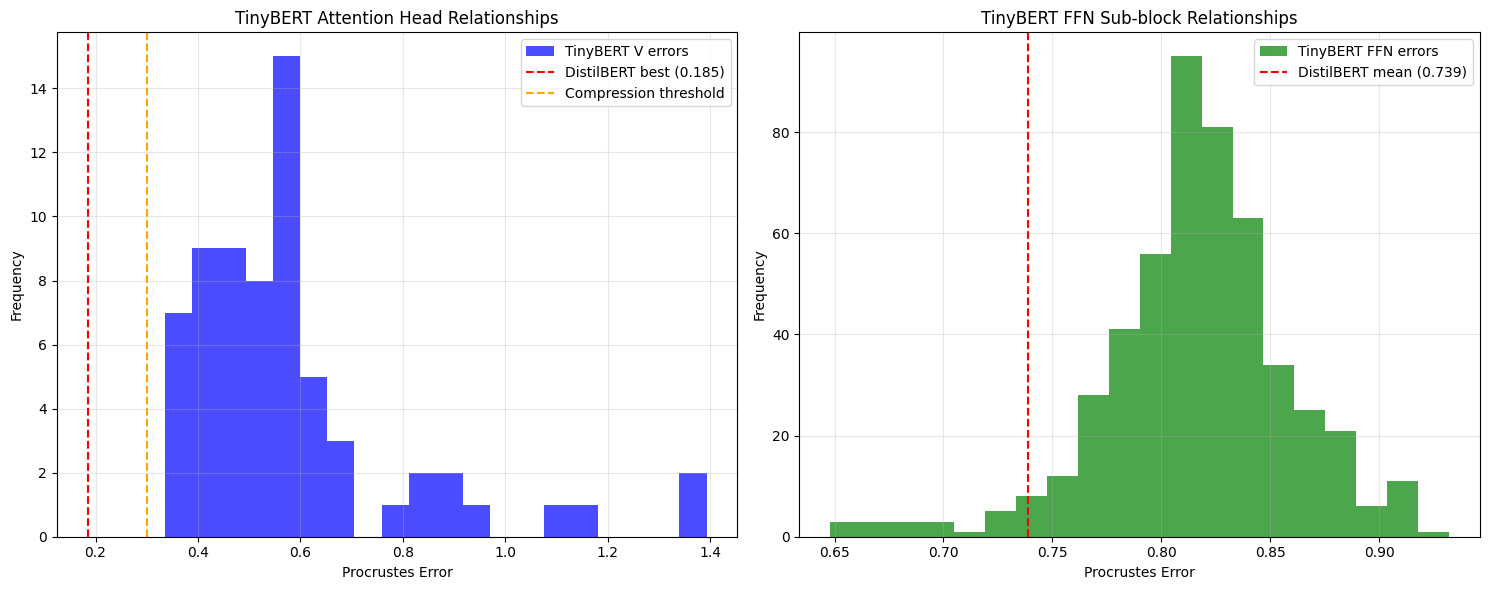


TINYBERT ANALYSIS COMPLETE


In [ ]:
import torch
import numpy as np
from transformers import BertModel, BertTokenizer
from scipy.linalg import orthogonal_procrustes
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import pandas as pd

def load_tinybert():
    """
    Load TinyBERT model and extract attention matrices
    TinyBERT-4L-312D: 4 layers, 12 heads, 312 hidden dim
    """
    # Load TinyBERT model
    model_name = "huawei-noah/TinyBERT_General_4L_312D"
    model = BertModel.from_pretrained(model_name)

    print(f"TinyBERT Model Configuration:")
    print(f"  Layers: {model.config.num_hidden_layers}")
    print(f"  Attention heads: {model.config.num_attention_heads}")
    print(f"  Hidden size: {model.config.hidden_size}")
    print(f"  Intermediate size: {model.config.intermediate_size}")

    return model

def extract_attention_matrices(model, layer_idx=0):
    """Extract Q, K, V matrices from specified layer"""
    attention_layer = model.encoder.layer[layer_idx].attention.self

    # Extract weight matrices
    query_weight = attention_layer.query.weight.data.numpy()  # [hidden_size, hidden_size]
    key_weight = attention_layer.key.weight.data.numpy()
    value_weight = attention_layer.value.weight.data.numpy()

    print(f"\nAttention Matrix Shapes (Layer {layer_idx}):")
    print(f"  Query: {query_weight.shape}")
    print(f"  Key: {key_weight.shape}")
    print(f"  Value: {value_weight.shape}")

    # Calculate head dimension
    hidden_size = model.config.hidden_size
    num_heads = model.config.num_attention_heads
    head_dim = hidden_size // num_heads

    print(f"  Head dimension: {head_dim}")
    print(f"  Total heads: {num_heads}")

    # Reshape matrices into individual heads
    query_heads = query_weight.reshape(num_heads, head_dim, hidden_size)
    key_heads = key_weight.reshape(num_heads, head_dim, hidden_size)
    value_heads = value_weight.reshape(num_heads, head_dim, hidden_size)

    return query_heads, key_heads, value_heads, head_dim

def extract_ffn_matrix(model, layer_idx=0):
    """Extract FFN Linear1 matrix from specified layer"""
    ffn_layer = model.encoder.layer[layer_idx].intermediate.dense
    linear1_weight = ffn_layer.weight.data.numpy()

    print(f"\nFFN Matrix Shape (Layer {layer_idx}):")
    print(f"  Linear1: {linear1_weight.shape}")
    print(f"  Total parameters: {linear1_weight.size}")

    return linear1_weight

def attention_procrustes_analysis(query_heads, key_heads, value_heads):
    """
    Perform Procrustes analysis on attention head relationships
    (Same as DistilBERT analysis but adapted for TinyBERT dimensions)
    """
    num_heads = query_heads.shape[0]
    results = []

    print(f"\nAnalyzing attention head relationships...")
    print(f"Number of heads: {num_heads}")
    print(f"Head pairs to analyze: {num_heads * (num_heads - 1) // 2}")

    for i in range(num_heads):
        for j in range(i + 1, num_heads):
            # Extract head matrices
            q_i, k_i, v_i = query_heads[i], key_heads[i], value_heads[i]
            q_j, k_j, v_j = query_heads[j], key_heads[j], value_heads[j]

            # Compute Procrustes analysis for each matrix type
            try:
                # Query matrices
                R_q, _ = orthogonal_procrustes(q_i, q_j)
                q_transformed = q_i @ R_q
                q_error = np.linalg.norm(q_transformed - q_j, 'fro') / np.linalg.norm(q_j, 'fro')

                # Key matrices
                R_k, _ = orthogonal_procrustes(k_i, k_j)
                k_transformed = k_i @ R_k
                k_error = np.linalg.norm(k_transformed - k_j, 'fro') / np.linalg.norm(k_j, 'fro')

                # Value matrices
                R_v, _ = orthogonal_procrustes(v_i, v_j)
                v_transformed = v_i @ R_v
                v_error = np.linalg.norm(v_transformed - v_j, 'fro') / np.linalg.norm(v_j, 'fro')

                results.append({
                    'head_i': i,
                    'head_j': j,
                    'q_error': q_error,
                    'k_error': k_error,
                    'v_error': v_error
                })

            except Exception as e:
                print(f"Error processing heads {i}-{j}: {e}")
                continue

    return results

def ffn_block_analysis(linear1_weight, block_size=32):
    """
    Analyze FFN sub-blocks (using smaller blocks for TinyBERT's smaller dimensions)
    """
    print(f"\nAnalyzing FFN sub-blocks...")
    print(f"Matrix shape: {linear1_weight.shape}")
    print(f"Block size: {block_size}x{block_size}")

    # Extract blocks
    rows, cols = linear1_weight.shape
    num_row_blocks = rows // block_size
    num_col_blocks = cols // block_size

    print(f"Number of complete blocks: {num_row_blocks} x {num_col_blocks} = {num_row_blocks * num_col_blocks}")

    blocks = []
    positions = []

    for i in range(num_row_blocks):
        for j in range(num_col_blocks):
            start_row = i * block_size
            end_row = start_row + block_size
            start_col = j * block_size
            end_col = start_col + block_size

            block = linear1_weight[start_row:end_row, start_col:end_col]
            blocks.append(block)
            positions.append((i, j))

    # Analyze block relationships
    results = []
    max_pairs = min(500, len(blocks) * (len(blocks) - 1) // 2)  # Limit for efficiency

    pair_count = 0
    for i in range(len(blocks)):
        for j in range(i + 1, len(blocks)):
            if pair_count >= max_pairs:
                break

            try:
                block_a, block_b = blocks[i], blocks[j]
                R, _ = orthogonal_procrustes(block_a, block_b)
                transformed = block_a @ R
                error = np.linalg.norm(transformed - block_b, 'fro') / np.linalg.norm(block_b, 'fro')

                results.append({
                    'block_i': i,
                    'block_j': j,
                    'pos_i': positions[i],
                    'pos_j': positions[j],
                    'error': error
                })

                pair_count += 1

            except Exception as e:
                continue

        if pair_count >= max_pairs:
            break

    return results

def compare_with_distilbert_results(attention_results, ffn_results):
    """
    Compare TinyBERT results with DistilBERT patterns
    """
    print(f"\n{'='*60}")
    print("COMPARISON WITH DISTILBERT RESULTS")
    print(f"{'='*60}")

    # Attention head analysis
    if attention_results:
        v_errors = [r['v_error'] for r in attention_results]
        q_errors = [r['q_error'] for r in attention_results]
        k_errors = [r['k_error'] for r in attention_results]

        print(f"\nTinyBERT Attention Head Relationships:")
        print(f"  V matrix errors - Mean: {np.mean(v_errors):.3f}, Min: {np.min(v_errors):.3f}")
        print(f"  K matrix errors - Mean: {np.mean(k_errors):.3f}, Min: {np.min(k_errors):.3f}")
        print(f"  Q matrix errors - Mean: {np.mean(q_errors):.3f}, Min: {np.min(q_errors):.3f}")

        # Find best relationships
        best_v = min(attention_results, key=lambda x: x['v_error'])
        print(f"\n  Best V relationship: Heads ({best_v['head_i']}, {best_v['head_j']}) - Error: {best_v['v_error']:.3f}")

        print(f"\n  Comparison to DistilBERT:")
        print(f"    DistilBERT best V error: ~0.185")
        print(f"    TinyBERT best V error: {np.min(v_errors):.3f}")
        if np.min(v_errors) < 0.3:
            print(f"    → TinyBERT shows PROMISING functional relationships!")
        else:
            print(f"    → TinyBERT shows weaker relationships than DistilBERT")

    # FFN analysis
    if ffn_results:
        ffn_errors = [r['error'] for r in ffn_results]

        print(f"\nTinyBERT FFN Sub-block Relationships:")
        print(f"  Mean error: {np.mean(ffn_errors):.3f}")
        print(f"  Min error: {np.min(ffn_errors):.3f}")
        print(f"  Std error: {np.std(ffn_errors):.3f}")

        print(f"\n  Comparison to DistilBERT:")
        print(f"    DistilBERT FFN errors: ~0.651-0.794 (mean 0.739)")
        print(f"    TinyBERT FFN errors: {np.min(ffn_errors):.3f}-{np.max(ffn_errors):.3f} (mean {np.mean(ffn_errors):.3f})")

def analyze_compression_implications(attention_results, ffn_results):
    """
    Analyze compression opportunities in TinyBERT
    """
    print(f"\n{'='*60}")
    print("COMPRESSION IMPLICATIONS")
    print(f"{'='*60}")

    if attention_results:
        # Count strong relationships
        strong_v_relationships = sum(1 for r in attention_results if r['v_error'] < 0.3)
        moderate_v_relationships = sum(1 for r in attention_results if 0.3 <= r['v_error'] < 0.5)

        print(f"Attention Head Compression Potential:")
        print(f"  Strong relationships (error < 0.3): {strong_v_relationships}")
        print(f"  Moderate relationships (error < 0.5): {moderate_v_relationships}")

        if strong_v_relationships > 0:
            print(f"  → Estimated additional compression: ~{strong_v_relationships * 30}% of attention parameters")

        # Best compression candidate
        best_relationship = min(attention_results, key=lambda x: x['v_error'])
        if best_relationship['v_error'] < 0.5:
            print(f"\n  Best compression target:")
            print(f"    Heads ({best_relationship['head_i']}, {best_relationship['head_j']})")
            print(f"    V error: {best_relationship['v_error']:.3f}")
            print(f"    Potential parameter reduction: ~50% for this head pair")

def plot_tinybert_comparisons(attention_results, ffn_results):
    """
    Create visualizations comparing TinyBERT to DistilBERT patterns
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Attention head error distribution
    if attention_results:
        v_errors = [r['v_error'] for r in attention_results]
        axes[0].hist(v_errors, bins=20, alpha=0.7, color='blue', label='TinyBERT V errors')
        axes[0].axvline(0.185, color='red', linestyle='--', label='DistilBERT best (0.185)')
        axes[0].axvline(0.3, color='orange', linestyle='--', label='Compression threshold')
        axes[0].set_xlabel('Procrustes Error')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title('TinyBERT Attention Head Relationships')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

    # FFN block error distribution
    if ffn_results:
        ffn_errors = [r['error'] for r in ffn_results]
        axes[1].hist(ffn_errors, bins=20, alpha=0.7, color='green', label='TinyBERT FFN errors')
        axes[1].axvline(0.739, color='red', linestyle='--', label='DistilBERT mean (0.739)')
        axes[1].set_xlabel('Procrustes Error')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('TinyBERT FFN Sub-block Relationships')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def main():
    """
    Main analysis pipeline for TinyBERT
    """
    print("TinyBERT Functional Relationship Analysis")
    print("="*60)

    # Load TinyBERT model
    model = load_tinybert()

    # Extract matrices from layer 0
    query_heads, key_heads, value_heads, head_dim = extract_attention_matrices(model, layer_idx=0)
    linear1_weight = extract_ffn_matrix(model, layer_idx=0)

    # Analyze attention head relationships
    print(f"\n{'='*50}")
    print("ATTENTION HEAD ANALYSIS")
    print(f"{'='*50}")
    attention_results = attention_procrustes_analysis(query_heads, key_heads, value_heads)

    # Analyze FFN sub-blocks (using smaller blocks for TinyBERT)
    print(f"\n{'='*50}")
    print("FFN SUB-BLOCK ANALYSIS")
    print(f"{'='*50}")
    ffn_results = ffn_block_analysis(linear1_weight, block_size=32)

    # Compare with DistilBERT results
    compare_with_distilbert_results(attention_results, ffn_results)

    # Analyze compression implications
    analyze_compression_implications(attention_results, ffn_results)

    # Create visualizations
    plot_tinybert_comparisons(attention_results, ffn_results)

    print(f"\n{'='*60}")
    print("TINYBERT ANALYSIS COMPLETE")
    print(f"{'='*60}")

    return attention_results, ffn_results

if __name__ == "__main__":
    attention_results, ffn_results = main()